In [1]:
! pip install dash dash-bootstrap-components plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 22.1 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.1
    Uninstalling Flask-3.1.1:
      Successfully uninstalled Flask-3.1.1


## LSTM

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
## LSTM
import random
import numpy as np
import torch
import pandas as pd

# # 시드 고정 (여기에 추가)
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
train = pd.read_csv('/content/merged_train (1).csv')
test = pd.read_csv('/content/merged_test (1).csv')
train.columns = [c.lower().strip() for c in train.columns]
test.columns = [c.lower().strip() for c in test.columns]
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
data = pd.concat([train, test], axis=0).reset_index(drop=True)

seq_length = 5
pred_size = 6
train = data[:-pred_size].copy()
test = data[-(pred_size + seq_length):].copy()


target_col = 'close'
date_col = 'date'
feature_cols = ['neu','trend', 'close']

[Epoch 1] Train Loss: 0.0701
[Epoch 2] Train Loss: 0.0690
[Epoch 3] Train Loss: 0.0635
[Epoch 4] Train Loss: 0.0451
[Epoch 5] Train Loss: 0.0420
[Epoch 6] Train Loss: 0.0418
[Epoch 7] Train Loss: 0.0389
[Epoch 8] Train Loss: 0.0270
[Epoch 9] Train Loss: 0.0351
[Epoch 10] Train Loss: 0.0162
[Epoch 11] Train Loss: 0.0236
[Epoch 12] Train Loss: 0.0121
[Epoch 13] Train Loss: 0.0275
[Epoch 14] Train Loss: 0.0219
[Epoch 15] Train Loss: 0.0290
[Epoch 16] Train Loss: 0.0262
[Epoch 17] Train Loss: 0.0179
[Epoch 18] Train Loss: 0.0139
[Epoch 19] Train Loss: 0.0086
[Epoch 20] Train Loss: 0.0195
[Epoch 21] Train Loss: 0.0126
[Epoch 22] Train Loss: 0.0054
[Epoch 23] Train Loss: 0.0123
[Epoch 24] Train Loss: 0.0083
[Epoch 25] Train Loss: 0.0237
[Epoch 26] Train Loss: 0.0108
[Epoch 27] Train Loss: 0.0253
[Epoch 28] Train Loss: 0.0156
[Epoch 29] Train Loss: 0.0091
[Epoch 30] Train Loss: 0.0099
[Epoch 31] Train Loss: 0.0081
[Epoch 32] Train Loss: 0.0166
[Epoch 33] Train Loss: 0.0179
[Epoch 34] Train Lo

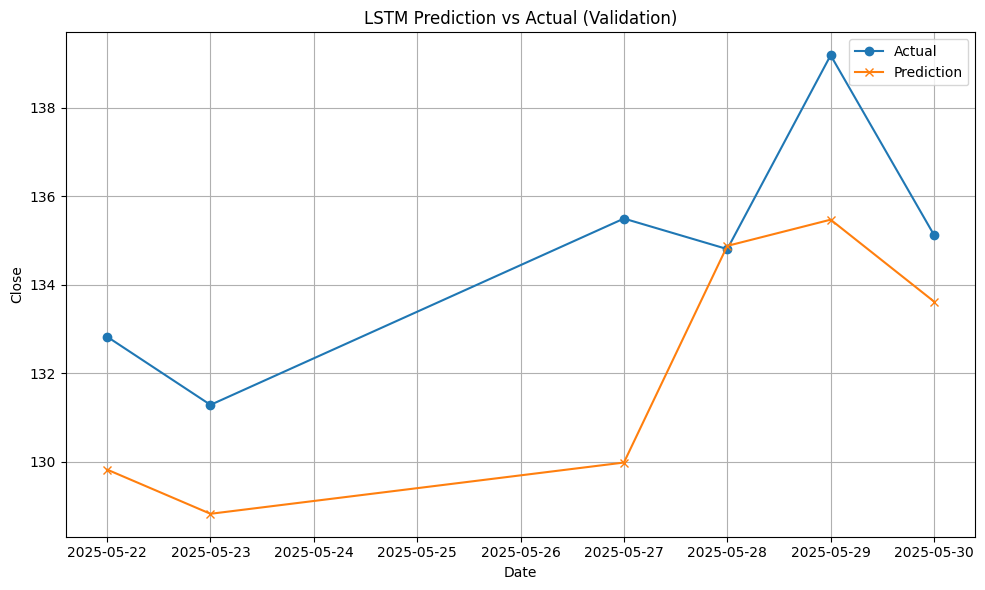

In [6]:
# 입력 스케일링
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train[feature_cols])
scaled_test = scaler.transform(test[feature_cols])

# 타깃(close) 스케일링 (예측 대상)
close_scaler = MinMaxScaler()
scaled_close_train = close_scaler.fit_transform(train[[target_col]]).flatten()
scaled_close_test = close_scaler.transform(test[[target_col]]).flatten()

# 시퀀스 생성 함수
def create_sequences(X, y, seq_length):
    xs, ys = [], []
    for i in range(len(X) - seq_length):
        xs.append(X[i:i+seq_length])          # (seq_length, input_size)
        ys.append(y[i + seq_length])          # close(t+1)
    return np.array(xs), np.array(ys)

# 시퀀스 생성
X_train, y_train = create_sequences(scaled_train, scaled_close_train, seq_length)
X_test, y_test = create_sequences(scaled_test, scaled_close_test, seq_length)

# 텐서 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

## tensor dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

## Dataloader
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True, drop_last = True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=False)

# LSTM 모델 정의
class LSTM(nn.Module):
    def __init__(self, input_size, seq_len, hidden_size=32, num_layers=2, output_size=1):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size, bias = True)

    def reset_hidden_state(self):
      self.hidden = (
          torch.zeros(self.num_layers, self.seq_len, self.hidden_size),
          torch.zeros(self.num_layers, self.seq_len, self.hidden_size),
          )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 시점만
        return out

# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(
    input_size=len(feature_cols),
    seq_len = seq_length
    ).to(device)  # ✅ 3 features: close, neu, trend

optimizer = torch.optim.AdamW(model.parameters(), lr=0.005, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma = 0.4)
criterion = nn.MSELoss()
num_epochs = 100
patience = 20

train_loss = np.zeros(num_epochs)

for epoch in range(1, num_epochs + 1):
  train_epoch_loss = 0
  model.train()
  for _, data in enumerate(train_loader):
    x_data, y_data = data

    optimizer.zero_grad()

    model.reset_hidden_state()
    output = model(x_data)

    loss = criterion(output, y_data)

    loss.backward()
    optimizer.step()
  # train_loss[epoch] = loss / len(train_loader)
  # scheduler.step()

  if epoch % 1 == 0 or epoch == 1:
      print(f"[Epoch {epoch}] Train Loss: {loss.item():.4f}")

  ## early stop
  # if (epoch % patience == 0) and (epoch > 0):
  #   print(epoch, patience)
  #   if train_loss[epoch - patience] < train_loss[epoch]:
  #     break

# 예측
model.eval()
with torch.no_grad():
  model.reset_hidden_state()
  preds_val = model(X_test.to(device)).cpu().numpy().flatten()

# 역변환
preds_val_inv = close_scaler.inverse_transform(preds_val.reshape(-1, 1)).flatten()
y_test_inv = close_scaler.inverse_transform(y_test.numpy().reshape(-1, 1)).flatten()

# 평가
mae = mean_absolute_error(y_test_inv, preds_val_inv)
rmse = mean_squared_error(y_test_inv, preds_val_inv)
print(f"\n[Validation] MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# 시각화
val_dates = test['date'].values[seq_length:]
plt.figure(figsize=(10, 6))
plt.plot(val_dates, y_test_inv, label='Actual', marker='o')
plt.plot(val_dates, preds_val_inv, label='Prediction', marker='x')
plt.title("LSTM Prediction vs Actual (Validation)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
torch.save(model.state_dict(), './checkpoint_250607_0132.pth')

#Dash

In [8]:

import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.graph_objs as go

# 예측 결과 불러오기
df = pd.read_csv('/content/merged_test (1).csv')
df['date'] = pd.to_datetime(df['date'])


df = df.iloc[:len(preds_val_inv)].copy()  # 길이 맞춰서 자르기
df['predicted_Close'] = preds_val_inv

# Dash 앱 초기화
app = dash.Dash(__name__)
server = app.server

# 앱 레이아웃
app.layout = html.Div([
    html.H1("LSTM 주가 예측 대시보드"),
    dcc.Slider(
        id='day-slider',
        min=0,
        max=len(df)-1,
        value=0,
        marks={i: str(date.date()) for i, date in enumerate(df['date'])},
        step=None
    ),
    dcc.Graph(id='prediction-graph'),
    html.Div(id='stats-output')
])

@app.callback(
    Output('prediction-graph', 'figure'),
    Output('stats-output', 'children'),
    Input('day-slider', 'value')
)
def update_graph(selected_day):
    selected_date = df['date'].iloc[selected_day]
    sub_df = df.iloc[:selected_day+1]

    # 실제 vs 예측 선그래프
    fig_price = go.Figure([
        go.Scatter(x=sub_df['date'], y=sub_df['Close'], mode='lines+markers', name='실제 Close'),
        go.Scatter(x=sub_df['date'], y=sub_df['predicted_Close'], mode='lines+markers', name='예측 Close')
    ])
    fig_price.update_layout(title='예측 vs 실제 (일별 업데이트)', xaxis_title='날짜', yaxis_title='가격')

    # 감성 점수 가져오기
    pos = df['pos'].iloc[selected_day]
    neu = df['neu'].iloc[selected_day]
    neg = df['neg'].iloc[selected_day]

    # 감성 점수 막대 그래프
    sentiment_fig = dcc.Graph(
        figure=go.Figure(
            data=[
                go.Bar(x=['긍정 (pos)', '중립 (neu)', '부정 (neg)'], y=[pos, neu, neg])
            ],
            layout=go.Layout(
                title='감성 분석 결과',
                yaxis=dict(title='비율 (%)'),
                xaxis=dict(title='감성 종류')
            )
        )
    )

    # 요약 정보
    stats = html.Div([
        html.P(f"선택 날짜: {selected_date.date()}"),
        html.P(f"실제 Close: {df['Close'].iloc[selected_day]:.2f}"),
        html.P(f"예측 Close: {df['predicted_Close'].iloc[selected_day]:.2f}"),
        sentiment_fig
    ])

    return fig_price, stats


if __name__ == '__main__':
    app.run(debug=True)


<IPython.core.display.Javascript object>